### данные по нагрузке на сеть от генерации

In [2]:
import pandas as pd

df_ = pd.read_csv("hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv")

In [3]:
df_

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [12]:
df = pd.DataFrame()
df['datetime'] = pd.to_datetime(df_['time'], utc=True)
df['total_load_actual'] = df_['total load actual']

df['lag_1'] = df['total_load_actual'].shift(1)
df['lag_24'] = df['total_load_actual'].shift(24)
df['rolling_mean_3'] = df['total_load_actual'].shift(1).rolling(3).mean()
df['diff_1'] = df['total_load_actual'] - df['total_load_actual'].shift(1)
df['diff_24'] = df['total_load_actual'] - df['total_load_actual'].shift(24)
df['diff_2'] = df['diff_1'] - df['diff_1'].shift(1)

df['generation solar'] = df_['generation solar']
df['generation solar_lag_1'] = df['generation solar'].shift(1)
df['generation solar_lag_24'] = df['generation solar'].shift(24)

df = df.dropna().reset_index(drop=True)


### prophet + xgboost

In [14]:
from prophet import Prophet
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df_prophet = df[['datetime', 'total_load_actual']].copy()
df_prophet['ds'] = df_prophet['datetime'].dt.tz_localize(None)
df_prophet['y'] = df_prophet['total_load_actual']
df_prophet = df_prophet[['ds', 'y']]

train_size = int(len(df_prophet) * 0.8)
df_train_prophet = df_prophet.iloc[:train_size]
df_test_prophet = df_prophet.iloc[train_size:]

prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
prophet_model.fit(df_train_prophet)

future = df_test_prophet[['ds']].copy()
prophet_pred = prophet_model.predict(future)['yhat'].values

prophet_train_pred = prophet_model.predict(df_train_prophet[['ds']])['yhat'].values
residuals = df_train_prophet['y'].values - prophet_train_pred

21:34:09 - cmdstanpy - INFO - Chain [1] start processing
21:34:21 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
X = df.iloc[:train_size].drop(columns=['datetime', 'total_load_actual'])
y_resid = residuals

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X, y_resid)

resid_lower, resid_upper = np.percentile(residuals, [5, 95])

y_pred_hybrid = []
current_load = list(df['total_load_actual'].iloc[train_size - 24:train_size])
X_test = df.iloc[train_size:].drop(columns=['datetime', 'total_load_actual']).copy()
n_test = len(X_test)

for i in range(n_test):
    X_row = X_test.iloc[i].copy()
    X_row['lag_1'] = current_load[-1]
    X_row['lag_24'] = current_load[-24]
    X_row['rolling_mean_3'] = np.mean(current_load[-3:])
    X_row['diff_1'] = current_load[-1] - current_load[-2]
    X_row['diff_24'] = current_load[-1] - current_load[-24]
    X_row['diff_2'] = X_row['diff_1'] - (current_load[-2] - current_load[-3])
    X_row['generation solar_lag_1'] = X_test['generation solar'].iloc[i - 1] if i > 0 else df['generation solar'].iloc[
        train_size - 24 + i]
    X_row['generation solar_lag_24'] = X_test['generation solar'].iloc[i - 24] if i >= 24 else \
    df['generation solar'].iloc[train_size - 24 + i]

    resid_pred = xgb_model.predict(pd.DataFrame([X_row]))[0]
    resid_pred = np.clip(resid_pred, resid_lower, resid_upper)
    final_pred = prophet_pred[i] + resid_pred
    y_pred_hybrid.append(final_pred)
    current_load.append(final_pred)

RMSE 5117.778242253648


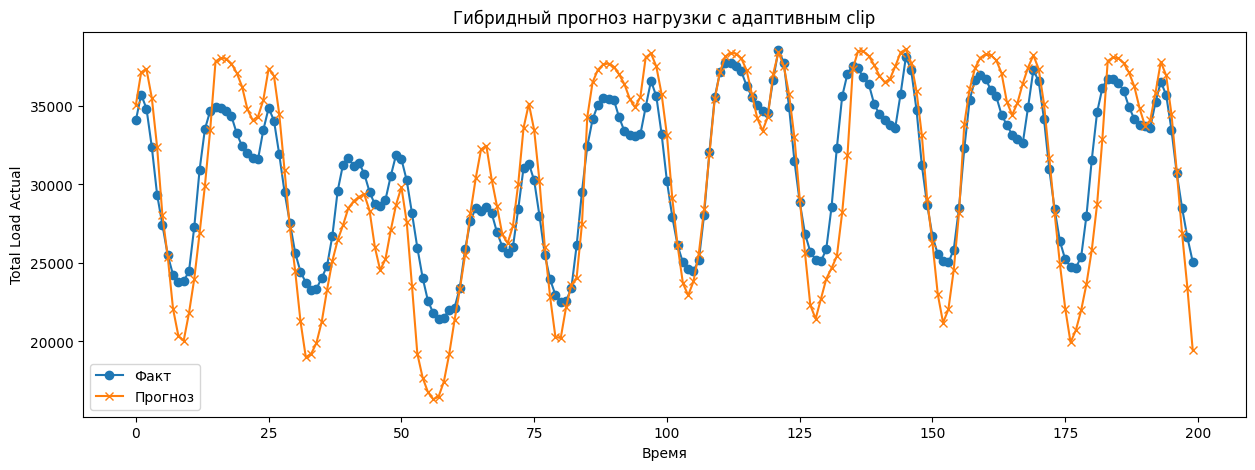

In [16]:
rmse = np.sqrt(mean_squared_error(df_test_prophet['y'].values, y_pred_hybrid))
print('RMSE', rmse)

plt.figure(figsize=(15, 5))
plt.plot(df_test_prophet['y'].values[:200], label='Факт', marker='o')
plt.plot(y_pred_hybrid[:200], label='Прогноз', marker='x')
plt.xlabel('Время')
plt.ylabel('Total Load Actual')
plt.title('Гибридный прогноз нагрузки с адаптивным clip')
plt.legend()
plt.show()